/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


thermalImageGrey311.jpg - PSNR: -40.08, SSIM: 0.0000
fusedImage164.jpg - PSNR: -35.21, SSIM: -0.0001
optrisImage222.jpg - PSNR: -37.14, SSIM: 0.0000
thermalImage165.jpg - PSNR: -31.63, SSIM: -0.1305
fusedImage431.jpg - PSNR: -35.13, SSIM: -0.0000
thermalImageGrey248.jpg - PSNR: -41.99, SSIM: 0.0001
thermalImageGrey37.jpg - PSNR: -38.98, SSIM: 0.0000
thermalImage273.jpg - PSNR: -33.21, SSIM: -0.1307
fusedImage452.jpg - PSNR: -35.41, SSIM: -0.0000
optrisImage50.jpg - PSNR: -36.48, SSIM: -0.0001


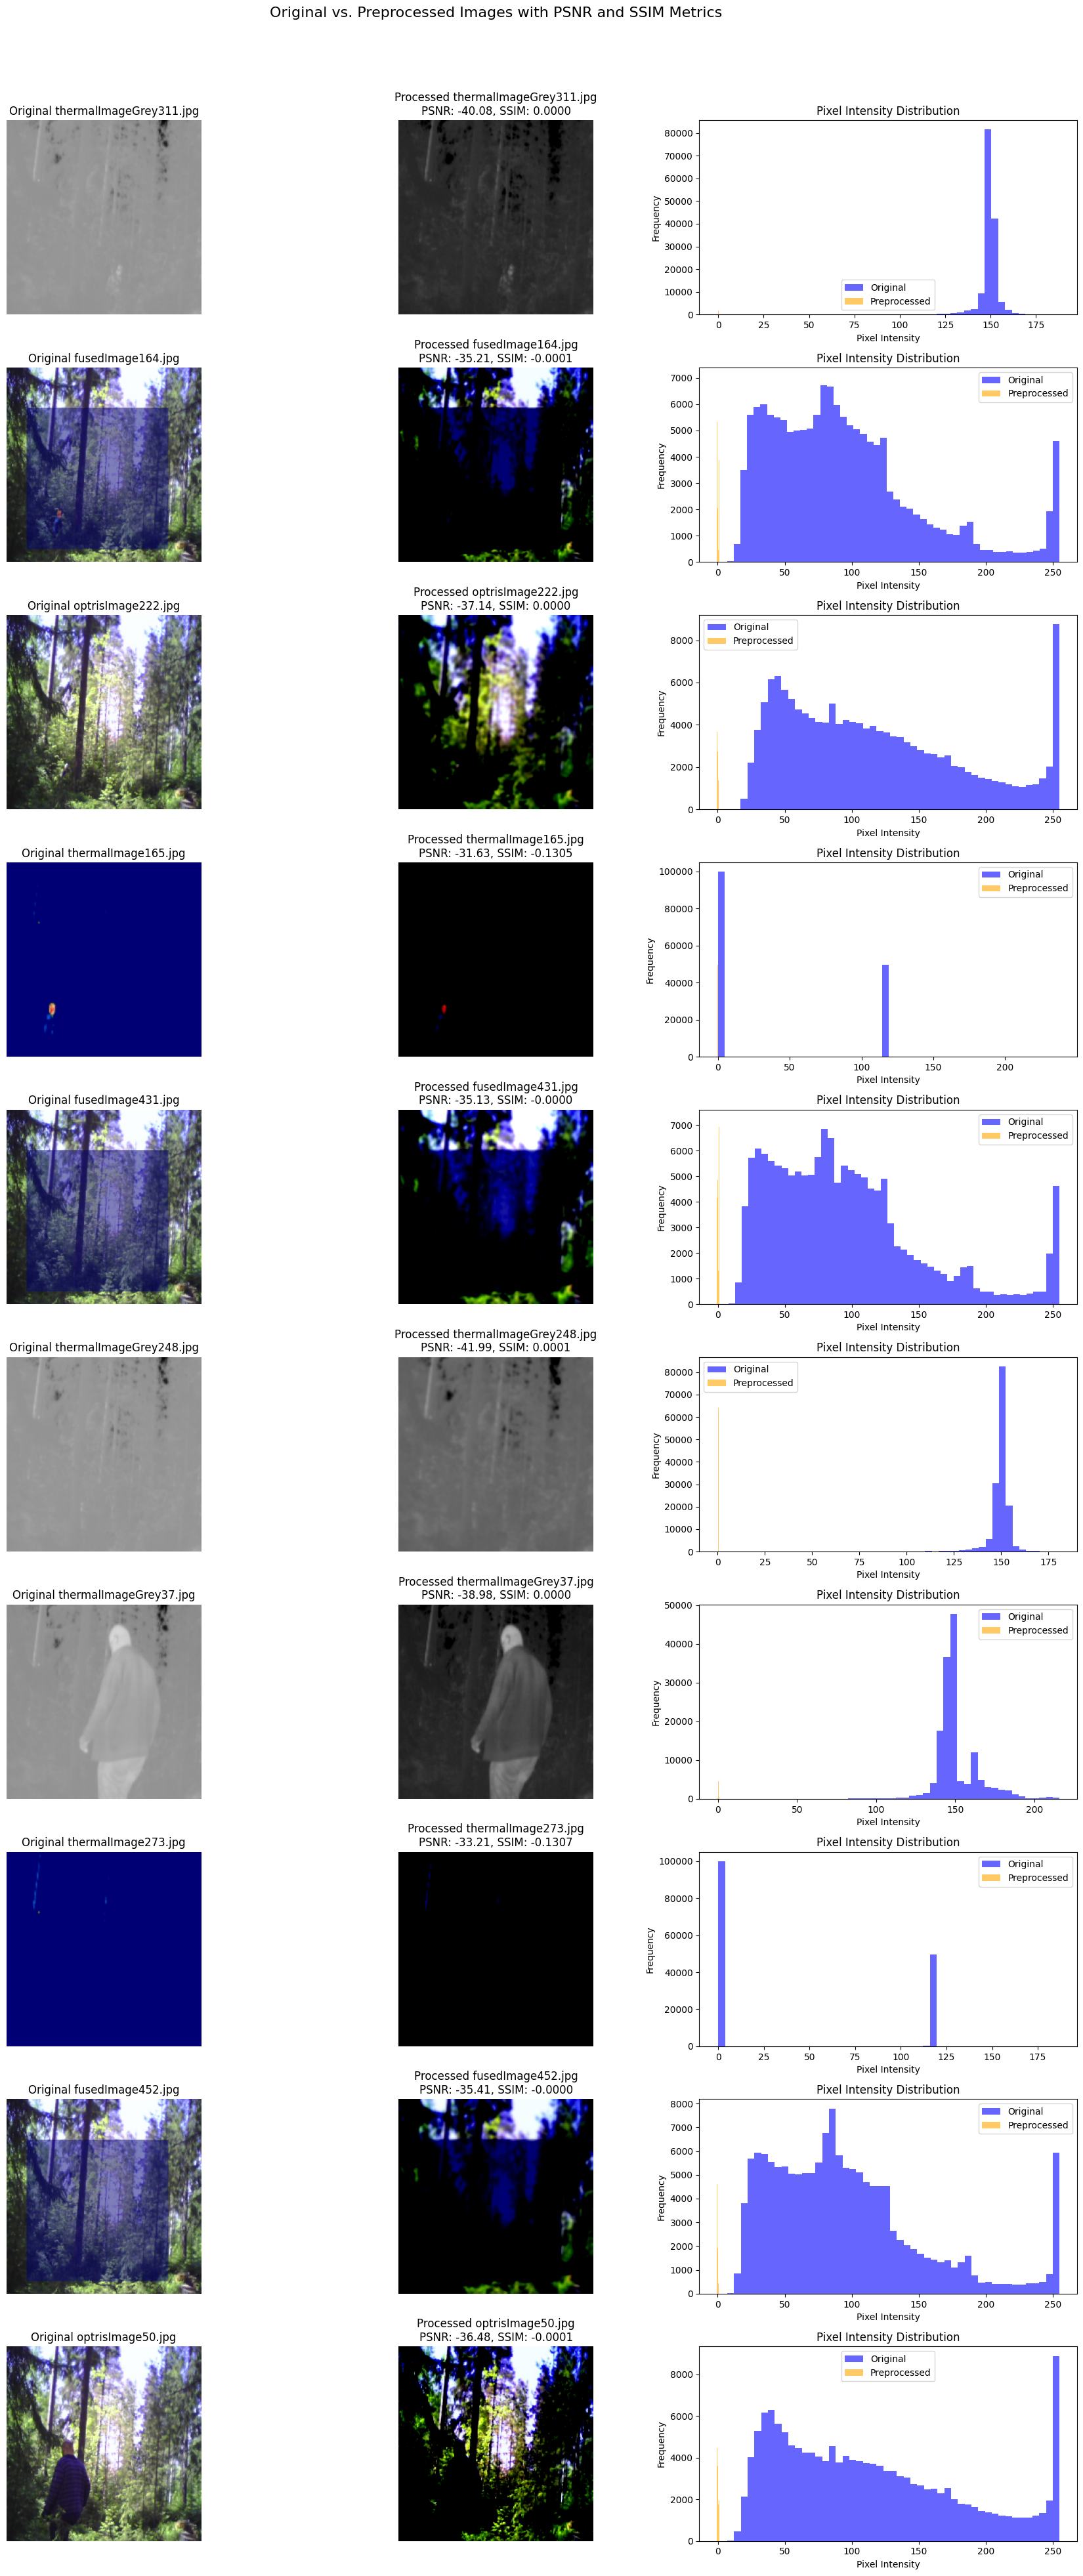

In [1]:
import os
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from albumentations import Compose, GaussianBlur, RandomBrightnessContrast, Resize, Normalize
from matplotlib import pyplot as plt

dataset_path = '/kaggle/input/ir-in-forestry-environments-aostovar/slu1_2014_06_24'
output_path = '/kaggle/working/preprocessed_images'
os.makedirs(output_path, exist_ok=True)

def preprocess_image(image):
    transform = Compose([
        GaussianBlur(blur_limit=(3, 7), p=0.5),
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        Resize(224, 224),
        Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    return transform(image=image)['image']

def load_and_preprocess_images(dataset_path, limit=10):
    images = []
    preprocessed_images = []
    titles = []

    for i, filename in enumerate(os.listdir(dataset_path)):
        if i >= limit:
            break
        img_path = os.path.join(dataset_path, filename)
        image = cv2.imread(img_path)

        if image is not None:
            # Resize the original image to 224x224
            resized_image = cv2.resize(image, (224, 224))
            images.append(resized_image)
            processed_image = preprocess_image(resized_image)
            preprocessed_images.append(processed_image)
            titles.append(filename)
            
            processed_image_path = os.path.join(output_path, f"processed_{filename}")
            cv2.imwrite(processed_image_path, cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))     

    return images, preprocessed_images, titles

def visualize_comparison(images, preprocessed_images, titles, max_images=10):
    num_images = min(len(images), max_images)
    rows, cols = 5, 2  # Arrange in 5 rows, 2 columns (Original and Processed pairs)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 20))
    fig.suptitle("Original vs. Preprocessed Images", fontsize=16)
    
    for i in range(num_images):
        row, col = divmod(i, cols)
        
        # Original Image
        ax_original = axes[row, 0]
        ax_original.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        ax_original.set_title(f'Original {titles[i]}')
        ax_original.axis('off')
        
        # Preprocessed Image
        ax_processed = axes[row, 1]
        ax_processed.imshow(cv2.cvtColor(preprocessed_images[i], cv2.COLOR_BGR2RGB))
        ax_processed.set_title(f'Processed {titles[i]}')
        ax_processed.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for main title
    plt.show()


# Calculate PSNR and SSIM metrics
def calculate_metrics(original, processed):
    psnr_value = psnr(original, processed, data_range=processed.max() - processed.min())
    ssim_value = ssim(cv2.cvtColor(original, cv2.COLOR_BGR2GRAY), cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY), 
                      data_range=processed.max() - processed.min())
    return psnr_value, ssim_value

def analyze_images(images, preprocessed_images, titles):
    psnr_values = []
    ssim_values = []

    for i in range(len(images)):
        psnr_value, ssim_value = calculate_metrics(images[i], preprocessed_images[i])
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)
        print(f"{titles[i]} - PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}")

    return psnr_values, ssim_values

def plot_pixel_intensity_subplots(images, preprocessed_images, titles, max_images=10):
    num_images = min(len(images), max_images)
    rows, cols = 5, 2
    fig, axes = plt.subplots(rows, cols, figsize=(15, 20))
    fig.suptitle("Pixel Intensity Distribution of Original vs Preprocessed Images", fontsize=16)
    
    for i in range(num_images):
        original = images[i].flatten()
        processed = preprocessed_images[i].flatten()
        row, col = divmod(i, cols)

        ax = axes[row, col]
        ax.hist(original, bins=50, color='blue', alpha=0.6, label='Original')
        ax.hist(processed, bins=50, color='orange', alpha=0.6, label='Preprocessed')
        ax.set_xlabel('Pixel Intensity')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{titles[i]}')
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for main title
    plt.show()
# the function below just the above two histogram and visualisation functions combined
#not really  needed but just  to improve it more visualaly pleasing 
def visualize_comparison_with_metrics(images, preprocessed_images, titles, psnr_values, ssim_values, max_images=10):
    num_images = min(len(images), max_images)
    rows, cols = num_images, 3  # 3 columns: Original, Preprocessed, Pixel Intensity
    fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * num_images))
    fig.suptitle("Original vs. Preprocessed Images with PSNR and SSIM Metrics", fontsize=16)

    for i in range(num_images):
        # Original Image
        ax_original = axes[i, 0]
        ax_original.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        ax_original.set_title(f'Original {titles[i]}')
        ax_original.axis('off')

        # Preprocessed Image with PSNR and SSIM values
        ax_processed = axes[i, 1]
        ax_processed.imshow(cv2.cvtColor(preprocessed_images[i], cv2.COLOR_BGR2RGB))
        ax_processed.set_title(f'Processed {titles[i]}\nPSNR: {psnr_values[i]:.2f}, SSIM: {ssim_values[i]:.4f}')
        ax_processed.axis('off')

        # Pixel Intensity Distribution
        original_intensity = images[i].flatten()
        processed_intensity = preprocessed_images[i].flatten()
        ax_histogram = axes[i, 2]
        ax_histogram.hist(original_intensity, bins=50, color='blue', alpha=0.6, label='Original')
        ax_histogram.hist(processed_intensity, bins=50, color='orange', alpha=0.6, label='Preprocessed')
        ax_histogram.set_xlabel('Pixel Intensity')
        ax_histogram.set_ylabel('Frequency')
        ax_histogram.set_title(f'Pixel Intensity Distribution')
        ax_histogram.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the main title
    plt.show()

# Main function
if __name__ == "__main__":
    images, preprocessed_images, titles = load_and_preprocess_images(dataset_path, limit=10)
    psnr_values, ssim_values = analyze_images(images, preprocessed_images, titles)
    visualize_comparison_with_metrics(images, preprocessed_images, titles, psnr_values, ssim_values)